On the last step of this project , i will move on with the classification.I will use three different supervised learning method: Naive Bayesian Classifier , Support Vector Machine and Neural Networks.Lets import all of the needed dependencies first.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import keras
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay

In [2]:
X=pd.read_csv('./data/preprocessed_final_data.csv',sep=',')
y=X['y']
X=X.drop(['y'],axis=1)

Since the minority class is only 11% of our dataset , this means it it going to be hard for our models to learn to classify it,thats why im going to use oversampling.
I will randomly select samples from the minority class and reproduce them in order for both classes to have the same number of records in the dataset.
This way i will help the supervised models to learn both classes.

In [3]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy="minority") #make minority class equal to majority
X,y=oversampler.fit_resample(X,y)

In order to continue with the classification process , we need to split our dataset into train and test datasets.I will use 30% of the dataset as the test size.

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

Now i will pass this data first to the Bayes Classifier.

In [5]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

GaussianNB()

Now our Gaussin Naive Bayes Classifier has been trained on the train dataset.
We need to see how well it will perform now on the test dataset , checking the accuracy and f1 score and the confusion matrix as well , in order to see how well it classifies each category.In order to do this we need the model to predict the output of the test dataset , and then compare it with the actual y_test (true output vs predicted output)

In [6]:
y_pred=gaussian.predict(X_test)

print("The Accuracy of the Gaussian Naive Bayes Classifier is : ",accuracy_score(y_test,y_pred))
print("The f1-score of the Gaussian Naive Bayes Classifier is : ",f1_score(y_test,y_pred))

The Accuracy of the Gaussian Naive Bayes Classifier is :  0.6782258486322507
The f1-score of the Gaussian Naive Bayes Classifier is :  0.584492773200054


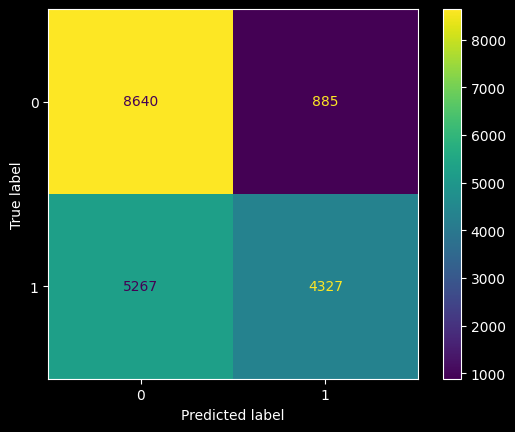

In [7]:
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

As we can see , the GNB Classifier performs really well on detecting the 'no' samples (true negatives), but does really bad on predicting the 'yes' samples (true positives) , as the size of the false negatives is larger than the true positives , whereas the false positives are a lot less compared to true negatives.

I will try to use a Support Vector Machine classifier now.In order to use this classifier , we have to convert our dataset to a numeric representation.
I will use PCA once again to accomplish this.

In [8]:
pca = PCA(0.90)
pca.fit(X)
PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print("The PCA components we need are: ",pca.n_components_)
t_d=pca.fit_transform(X)

The PCA components we need are:  13


In [9]:
X_train,X_test,y_train,y_test=train_test_split(t_d,y,test_size=0.3,random_state=42)

In [10]:
from sklearn import svm
svm_classifier=svm.SVC()
svm_classifier.fit(X_train,y_train)

SVC()

After we train the classifier , we once again check how it performed based on accuracy and f1-score.

In [11]:
y_pred=svm_classifier.predict(X_test) 

print("The Accuracy of the SVM Classifier is : ",accuracy_score(y_test,y_pred))
print("The f1-score of the SVM Classifier is : ",f1_score(y_test,y_pred))

The Accuracy of the SVM Classifier is :  0.7401014697421413
The f1-score of the SVM Classifier is :  0.7027576718310701


We also need to check the confusion matrix once again to determine if the classifier performed well on both classes.

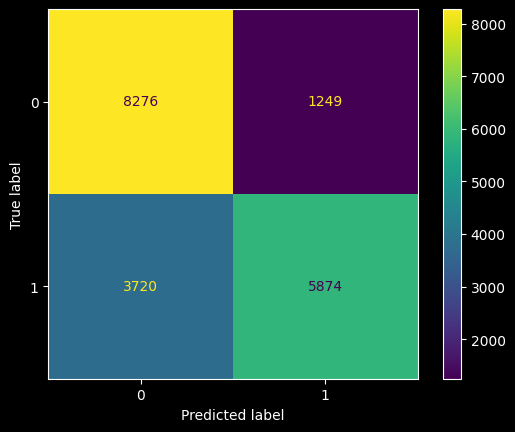

In [12]:
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

As we can see , the SVM classifier performed much better , by improving the true positive to false negative ratio , while at the same time it didnt change much the true negative false positive ratio.

The last classifier i am going to use is a neural network.In order to determine the appropriate number of layers and neurons per layer I experimented a lot and found out that using 2 layers with 512 neurons per layer on the initial dataset , without transforming it to a numeric representation , yielded the best results.
There is a change the model overfitted the data , but it performed relatively well on the test data as well.
Also I monitored the training process based on val_loss (the loss on test data ) with early stopping, in order to prevent overfitting.

First of all , we need to create a neural network with an input layer with a number of neurons equal to out dataset dimensionality.

In [13]:
print("The number of input layer neurons needed is : ",X.shape[1])

The number of input layer neurons needed is :  46


The output layer of our neural network is consisted of 1 neuron , which has a sigmoid activation function , meaning it returns a number between 0 and 1.
We can then set a threshhold to determine in which class an input is classified.Since i balanced the classes using oversampling , i will use 0.5 as the threshhold.

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [15]:
input_layer = keras.layers.Input(shape=(46,))
outputs=keras.layers.Dense(units=512, activation="relu")(input_layer)
outputs = keras.layers.Dense(units=512, activation="relu")(outputs)
outputs = keras.layers.Dense(units=1, activation="sigmoid")(outputs)
 
nn_model = keras.Model(inputs=input_layer, outputs=outputs)
nn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46)]              0         
                                                                 
 dense (Dense)               (None, 512)               24064     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 287,233
Trainable params: 287,233
Non-trainable params: 0
_________________________________________________________________


Now we need to set the learning rate parameter for the neural network.I will use a really small learning rate (1/train size) in order for the network to train appropriatelly on the data.Im going to use binary_crossentropy as a loss function since we have a binary classification problem.

In [16]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
from keras import backend as K
K.set_value(nn_model.optimizer.learning_rate, 1/X_train.shape[0])

The neural network is going to train for 200 epochs max.I will use the test data as validation data every epoch , because i have set early stopping based on the val_loss on test data , in order to avoid overfitting.

In [17]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_hist = nn_model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[callback],batch_size=256)
model_hist

Epoch 1/200
175/175 [==============================] - 2s 7ms/step - loss: 0.5955 - accuracy: 0.7036 - val_loss: 0.5617 - val_accuracy: 0.7158
Epoch 2/200
175/175 [==============================] - 1s 6ms/step - loss: 0.5502 - accuracy: 0.7292 - val_loss: 0.5487 - val_accuracy: 0.7287
Epoch 3/200
175/175 [==============================] - 1s 6ms/step - loss: 0.5424 - accuracy: 0.7342 - val_loss: 0.5441 - val_accuracy: 0.7296
Epoch 4/200
175/175 [==============================] - 1s 6ms/step - loss: 0.5388 - accuracy: 0.7351 - val_loss: 0.5421 - val_accuracy: 0.7306
Epoch 5/200
175/175 [==============================] - 1s 6ms/step - loss: 0.5365 - accuracy: 0.7376 - val_loss: 0.5402 - val_accuracy: 0.7324
Epoch 6/200
175/175 [==============================] - 1s 6ms/step - loss: 0.5345 - accuracy: 0.7378 - val_loss: 0.5385 - val_accuracy: 0.7334
Epoch 7/200
175/175 [==============================] - 1s 6ms/step - loss: 0.5328 - accuracy: 0.7392 - val_loss: 0.5375 - val_accuracy: 0.7353

In [18]:
y_pred=nn_model.predict(X_test) 
y_pred = np.where(y_pred > 0.5, 1, 0)

print("The f1-score of the Neural Network with a threshhold of 0.5 is: ",f1_score(y_test,y_pred))
print("The Accuracy of the Neural Network with a threshhold of 0.5 is: ",accuracy_score(y_test,y_pred))

598/598 [==============================] - 1s 893us/step
The f1-score of the Neural Network with a threshhold of 0.5 is:  0.7968277945619335
The Accuracy of the Neural Network with a threshhold of 0.5 is:  0.803023170667922


As we can see , the neural network has the best f1-score and accuracy on the test data compared to the other classifiers.

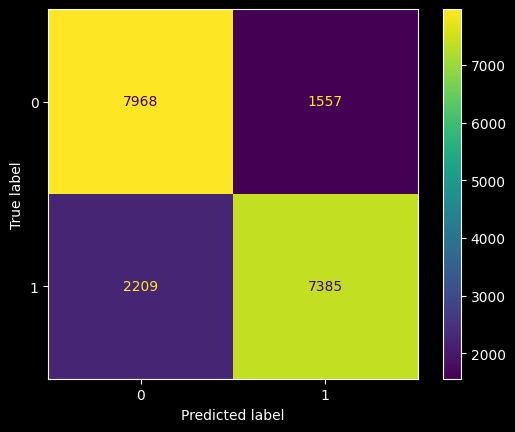

In [19]:
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Now lets check what AUC (Area Under the Curve) each classifier has.

In [20]:
from sklearn.metrics import roc_auc_score,roc_curve

gaussian_y_pred=gaussian.predict(X_test)
gaussian_fpr,gaussian_tpr,threshold=roc_curve(y_test,gaussian_y_pred,pos_label=1)
print("The AUC for the GNB Classifier is: ",roc_auc_score(y_test, gaussian_y_pred))

The AUC for the GNB Classifier is:  0.6790488313726263


In [21]:
X_train,X_test,y_train,y_test=train_test_split(t_d,y,test_size=0.3,random_state=42)

In [22]:
svm_y_pred=svm_classifier.predict(X_test)
svm_fpr,svm_tpr,threshold=roc_curve(y_test,svm_y_pred,pos_label=1)
print("The AUC for the SVM Classifier is: ",roc_auc_score(y_test, svm_y_pred))

The AUC for the SVM Classifier is:  0.7405645260571321


In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [24]:
nn_model_y_pred=nn_model.predict(X_test)
nn_model_fpr,nn_model_tpr,threshold=roc_curve(y_test,nn_model_y_pred,pos_label=1)
print("The AUC for the Neural Network is: ",roc_auc_score(y_test, nn_model_y_pred))

598/598 [==============================] - 1s 920us/step
The AUC for the Neural Network is:  0.8879233193099143


And now lets plot the ROC curve for each classifier.

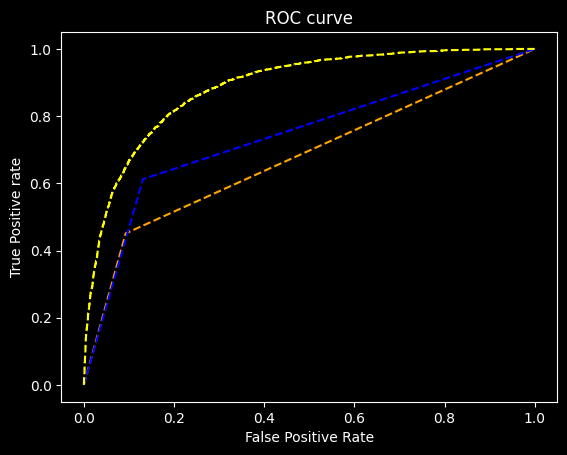

In [25]:
plt.plot(gaussian_fpr, gaussian_tpr, linestyle='--',color='orange', label='Gaussian Bayes')
plt.plot(svm_fpr, svm_tpr, linestyle='--', color='blue',label='SVM')
plt.plot(nn_model_fpr, nn_model_tpr, linestyle='--', color='yellow',label='Neural Network')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.show()

As we can see , the neural network outperformed the other classifiers and did a pretty good job.